In [1]:
#자기가 사용하는 gpu 할당
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=7

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=7


In [2]:
import time

import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
import os.path as osp

from torch.optim import Adam
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_geometric.data import DataLoader
from torch_geometric.datasets import ModelNet
from torch_geometric.nn import PointConv, radius_graph, fps, global_max_pool, XConv, fps, global_mean_pool
from torch_geometric.transforms import RadiusGraph

#import os
#os.environ["CUDA_VISIBLE_DEVICES"]
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
#torch.backends.cudnn.deterministic=True

In [3]:
def get_dataset(num_points, name='10'):
    path = 'ModelNet'+name
    pre_transform = T.NormalizeScale()
    transform = T.SamplePoints(num_points)

    train_dataset = ModelNet(
        'dataset/' + path,
        name=name,
        train=True,
        transform=transform,
        pre_transform=pre_transform)
    test_dataset = ModelNet(
        'dataset/' + path,
        name=name,
        train=False,
        transform=transform,
        pre_transform=pre_transform)

    return train_dataset, test_dataset


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

def run(train_dataset, test_dataset, model, epochs, batch_size, lr,
        lr_decay_factor, lr_decay_step_size, weight_decay):

    model = model.to(device)
    
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
    
    best_test_acc=0
    
    for epoch in range(1, epochs + 1):
        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_start = time.perf_counter()

        train(model, optimizer, train_loader, device)
        test_acc = test(model, test_loader, device)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()
    
       
        
        if best_test_acc<test_acc:
            best_test_acc=test_acc
            torch.save(model.state_dict(), "saves/{}.pth".format(model._get_name()))
        print('Epoch: {:03d}, Test: {:.4f}, Best_Test: {:.4f}, Duration: {:.2f}'.format(
            epoch, test_acc, best_test_acc,t_end - t_start))
        if epoch % lr_decay_step_size == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_decay_factor * param_group['lr']


def train(model, optimizer, train_loader, device):
    model.train()
    losses=0
    total = len(train_loader)
    interval = 100
    total = len(train_loader)//interval
    for i,data in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        out = model(data.pos, data.batch)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        losses+=loss
        optimizer.step()
        
        if (i+1)%interval==0:
            print("{}/{} loss : {:.4f}".format(int((i+1)/interval), total, losses/interval))
            losses=0

def test(model, test_loader, device):
    model.eval()

    correct = 0
    for data in test_loader:
        data = data.to(device)
        pred = model(data.pos, data.batch).max(1)[1]
        correct += pred.eq(data.y).sum().item()
    test_acc = correct / len(test_loader.dataset)

    return test_acc


def print_dataset(train_dataset, test_dataset):
    num_nodes = num_edges = 0
    for data in train_dataset:
        data = RadiusGraph(0.2)(data)
        num_nodes += data.num_nodes
        num_edges += data.num_edges
    for data in test_dataset:
        data = RadiusGraph(0.2)(data)
        num_nodes += data.num_nodes
        num_edges += data.num_edges

    num_graphs = len(train_dataset) + len(test_dataset)
    print('Graphs', num_graphs)
    print('Nodes', num_nodes / num_graphs)
    print('Edges', (num_edges // 2) / num_graphs)
    print('Label rate', len(train_dataset) / num_graphs)
    print()


In [5]:
class PointNet(torch.nn.Module):
    def __init__(self, num_classes):
        super(PointNet, self).__init__()

        nn = Seq(Lin(3, 64), ReLU(), Lin(64, 64))
        self.conv1 = PointConv(local_nn=nn)

        nn = Seq(Lin(67, 128), ReLU(), Lin(128, 128))
        self.conv2 = PointConv(local_nn=nn)

        nn = Seq(Lin(131, 256), ReLU(), Lin(256, 256))
        self.conv3 = PointConv(local_nn=nn)

        self.lin1 = Lin(256, 256)
        self.lin2 = Lin(256, 256)
        self.lin3 = Lin(256, num_classes)

    def forward(self, pos, batch):
        radius = 0.2
        edge_index = radius_graph(pos, r=radius, batch=batch)
        x = F.relu(self.conv1(None, pos, edge_index))

        idx = fps(pos, batch, ratio=0.5)
        x, pos, batch = x[idx], pos[idx], batch[idx]

        radius = 0.4
        edge_index = radius_graph(pos, r=radius, batch=batch)
        x = F.relu(self.conv2(x, pos, edge_index))

        idx = fps(pos, batch, ratio=0.25)
        x, pos, batch = x[idx], pos[idx], batch[idx]

        radius = 1
        edge_index = radius_graph(pos, r=radius, batch=batch)
        x = F.relu(self.conv3(x, pos, edge_index))

        x = global_max_pool(x, batch)

        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        return F.log_softmax(x, dim=-1)

class PointCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(PointCNN, self).__init__()

        self.conv1 = XConv(0, 48, dim=3, kernel_size=8, hidden_channels=32)
        self.conv2 = XConv(
            48, 96, dim=3, kernel_size=12, hidden_channels=64, dilation=2)
        self.conv3 = XConv(
            96, 192, dim=3, kernel_size=16, hidden_channels=128, dilation=2)
        self.conv4 = XConv(
            192, 384, dim=3, kernel_size=16, hidden_channels=256, dilation=2)

        self.lin1 = Lin(384, 256)
        self.lin2 = Lin(256, 128)
        self.lin3 = Lin(128, num_classes)

    def forward(self, pos, batch):
        x = F.relu(self.conv1(None, pos, batch))

        idx = fps(pos, batch, ratio=0.375)
        x, pos, batch = x[idx], pos[idx], batch[idx]

        x = F.relu(self.conv2(x, pos, batch))

        idx = fps(pos, batch, ratio=0.334)
        x, pos, batch = x[idx], pos[idx], batch[idx]

        x = F.relu(self.conv3(x, pos, batch))
        x = F.relu(self.conv4(x, pos, batch))

        x = global_mean_pool(x, batch)

        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        return F.log_softmax(x, dim=-1)


In [6]:
epochs=200
b_size=8
lr=0.001
lr_decay=0.5
lr_decay_step=50
weight_decay=0
train_dataset, test_dataset = get_dataset(1024)

In [ ]:
#Train
model = PointCNN(train_dataset.num_classes)
run(train_dataset, test_dataset, model, epochs, b_size, lr,
    lr_decay, lr_decay_step, weight_decay)

In [8]:
#load pretrained
PATH = "saves/"+model._get_name() +".pth"
model.load_state_dict(torch.load(PATH))
model.eval()

#test the loaded model
model = model.to(device)
test_loader = DataLoader(test_dataset, batch_size=b_size, shuffle=False)
test_acc = test(model,test_loader, device)
print ("test acc: {:.04f}".format(test_acc))

test acc: 0.9339


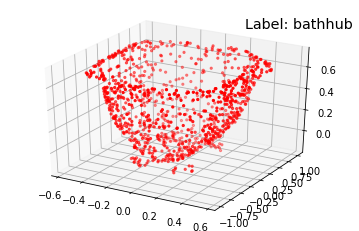

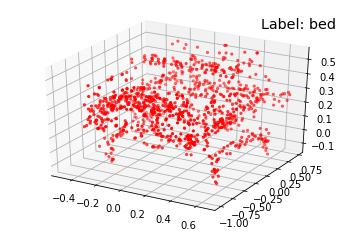

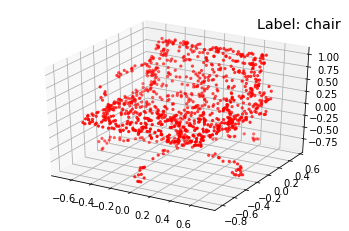

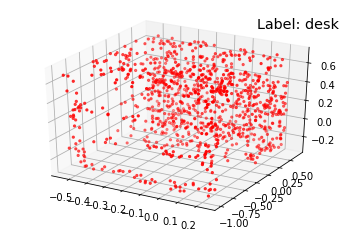

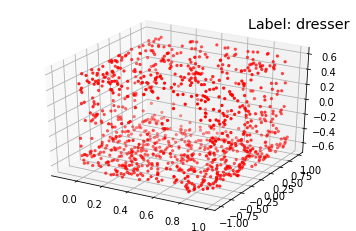

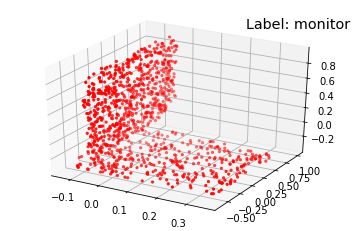

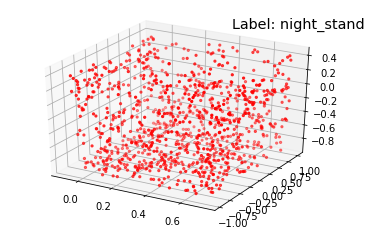

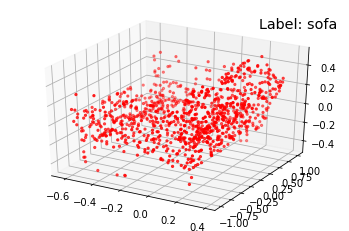

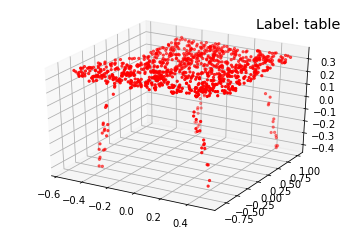

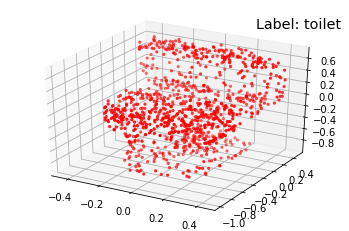

In [10]:
from utils import visualize

check=[]

for data in test_dataset:
    if data.y.item() not in check:
        pos = data.pos
        label = data.y.item()
        visualize(pos,label)
        check.append(data.y.item())

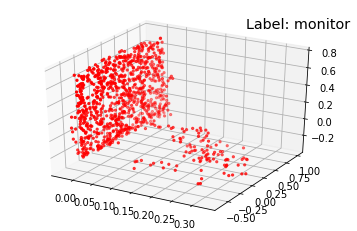

expected label : 5, answer label : 5


In [107]:
idx = 502
data=test_dataset[idx]
visualize(data.pos, data.y.item())
data=data.to(device)
pos = data.pos
score = model(pos, torch.zeros(1024, dtype=torch.long).to(device))
print("expected label : {}, answer label : {}".format(torch.argmax(score).item(), data.y.item()))


In [118]:
def fgsm_attack(pos, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_pos = pos + epsilon*sign_data_grad
    # Adding clipping to maintain [-1,1] range
    perturbed_pos = torch.clamp(perturbed_pos, -1, 1)
    # Return the perturbed image
    return perturbed_pos

pos.requires_grad = True
score = model(pos, torch.zeros(1024, dtype=torch.long).to(device))
loss = F.nll_loss(score, torch.tensor([3],dtype=torch.long).cuda())
# Zero all existing gradients
model.zero_grad()
# Calculate gradients of model in backward pass
loss.backward()
# Collect datagrad
data_grad = pos.grad.data

epsilon=0.1
perturbed_pos = fgsm_attack(pos, epsilon, data_grad)

output = model(perturbed_pos, torch.zeros(1024, dtype=torch.long).to(device))

print(loss, output)

tensor(120.7297, device='cuda:0', grad_fn=<NllLossBackward>) tensor([[-114.8155, -107.8148, -133.4419,  -79.7825,  -62.4033,    0.0000,
          -78.0450, -155.2430,  -95.7136,  -88.8032]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)


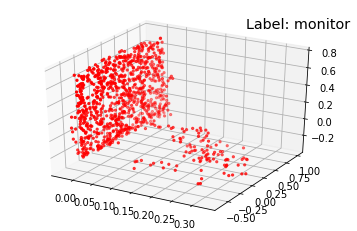

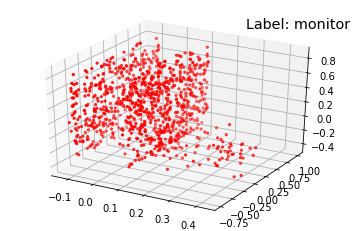

In [119]:
visualize(pos.cpu().detach(), data.y.item())
visualize(perturbed_pos.cpu().detach(), torch.argmax(output).item())